In [10]:
import os
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

In [11]:
data_path = os.path.join("processed_data", "AD00105.h5ad")
print(f"Reading data from: {data_path}")

adata = sc.read_h5ad(data_path)
print(f"Initial shape of AnnData: {adata.shape}")

Reading data from: processed_data\AD00105.h5ad
Initial shape of AnnData: (11542, 26845)


In [12]:
# Display basic information about the dataset
adata

AnnData object with n_obs × n_vars = 11542 × 26845
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.8', 'seurat_clusters', 'marker_cell_type', 'scina_cell_type', 'predicted.id', 'group', 'RNA_snn_res.4', 'cluster_group', 'healhy_cells_percent', 'combine_group_pathlogy', 'associate_cells', 'prediction.score.Oligodendrocytes', 'prediction.score.Oligodendrocyte.precursor.cells', 'prediction.score.Inhibitory.neurons', 'prediction.score.Excitatory.neurons', 'prediction.score.Microglia', 'prediction.score.Astrocytes', 'prediction.score.Endothelial.cells', 'prediction.score.max'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'

In [13]:
# Filter cells based on the number of genes
sc.pp.filter_cells(adata, min_genes=200)
adata = adata[adata.obs['n_genes'] < 8000, :]

# Filter genes based on the number of cells they are expressed in
sc.pp.filter_genes(adata, min_cells=3)
print(f"Shape after QC filters (cells/genes): {adata.shape}")

# Calculate QC metrics
sc.pp.calculate_qc_metrics(adata, inplace=True)

c:\Users\asus\miniconda3\envs\scbb\lib\site-packages\scanpy\preprocessing\_simple.py:284: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["n_cells"] = number


Shape after QC filters (cells/genes): (11541, 23846)


c:\Users\asus\miniconda3\envs\scbb\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\asus\miniconda3\envs\scbb\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


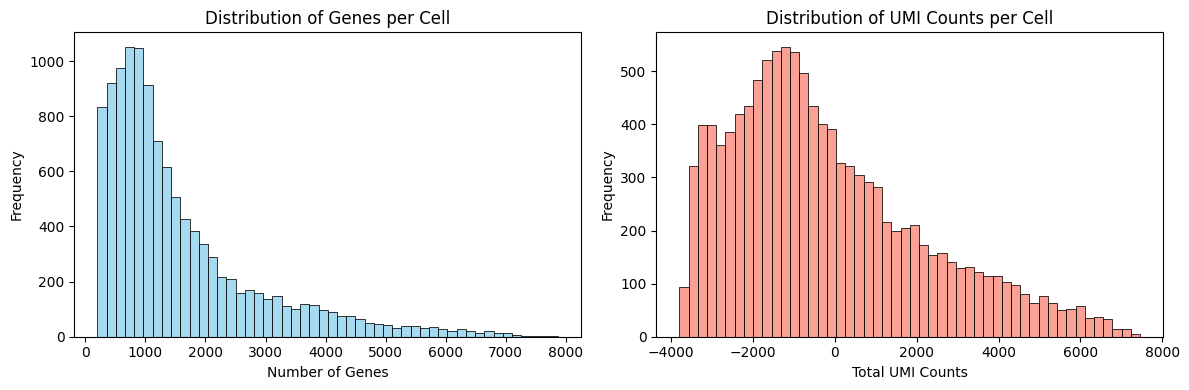

In [14]:
# Plot histograms for number of genes and total counts per cell
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(data=adata.obs, x='n_genes', bins=50, ax=axs[0], color='skyblue')
axs[0].set_title('Distribution of Genes per Cell')
axs[0].set_xlabel('Number of Genes')
axs[0].set_ylabel('Frequency')

sns.histplot(data=adata.obs, x='total_counts', bins=50, ax=axs[1], color='salmon')
axs[1].set_title('Distribution of UMI Counts per Cell')
axs[1].set_xlabel('Total UMI Counts')
axs[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [15]:
# Normalize the data so that each cell has a total count of 10,000
sc.pp.normalize_total(adata, target_sum=1e4)
# Log-transform the data
sc.pp.log1p(adata)

c:\Users\asus\miniconda3\envs\scbb\lib\site-packages\scanpy\preprocessing\_normalization.py:234: UserWarning: Some cells have zero counts
  warn(UserWarning("Some cells have zero counts"))
c:\Users\asus\miniconda3\envs\scbb\lib\site-packages\scanpy\preprocessing\_simple.py:383: RuntimeWarning: invalid value encountered in log1p
  np.log1p(X, out=X)


In [16]:
import scipy.sparse as sp

print("Checking for NaN values in the data...")
if sp.issparse(adata.X):
    X_dense = adata.X.toarray()
    nan_cells = np.isnan(X_dense).any(axis=1)
else:
    nan_cells = np.isnan(adata.X).any(axis=1)

num_nan_cells = np.sum(nan_cells)
if num_nan_cells > 0:
    print(f"Found {num_nan_cells} cells with NaN values. Removing them...")
    adata = adata[~nan_cells, :]
    print(f"Shape after removing cells with NaNs: {adata.shape}")
else:
    print("No NaN values found in the data.")

Checking for NaN values in the data...
Found 11541 cells with NaN values. Removing them...
Shape after removing cells with NaNs: (0, 23846)


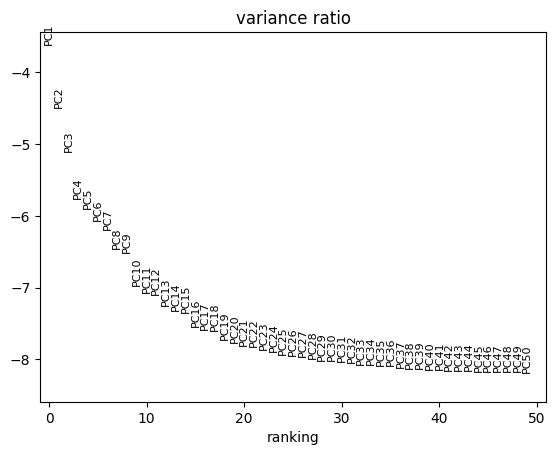

In [18]:
# Plot the variance ratio of the first 50 principal components
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=50)
plt.show()

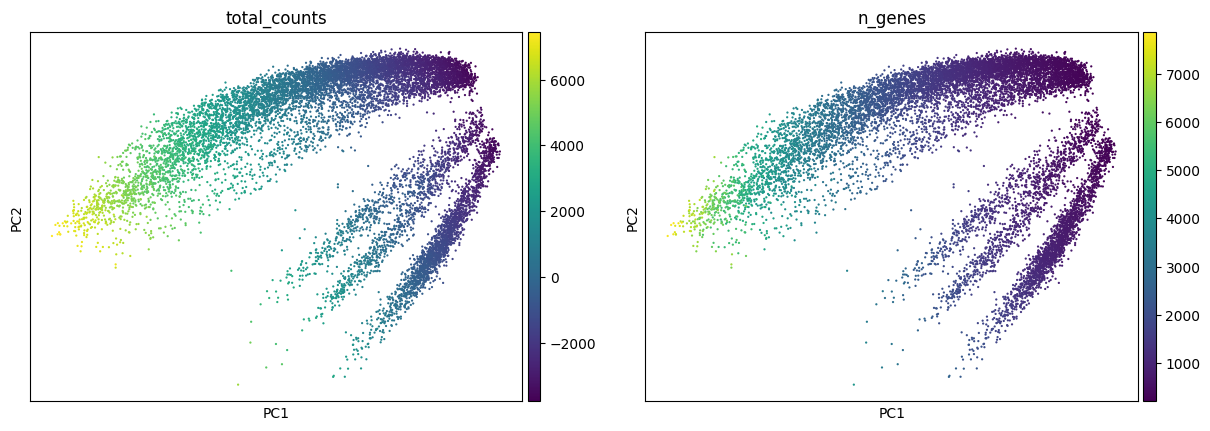

In [19]:
# Visualize the first two principal components
sc.pl.pca(adata, color=['total_counts', 'n_genes'])
plt.show()

In [29]:
# Compute the UMAP embedding
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
# Identify clusters using the Louvain algorithm
sc.tl.louvain(adata, resolution=0.8)
print(adata.obs['louvain'].value_counts())

louvain
0     1132
1     1024
2      918
3      756
4      739
5      709
6      661
7      638
8      586
9      489
10     475
11     463
12     412
13     357
14     352
15     303
16     270
17     247
18     229
19     223
20     191
21     160
22     110
23      97
Name: count, dtype: int64


Column 'batch' not found in adata.obs and will be skipped.


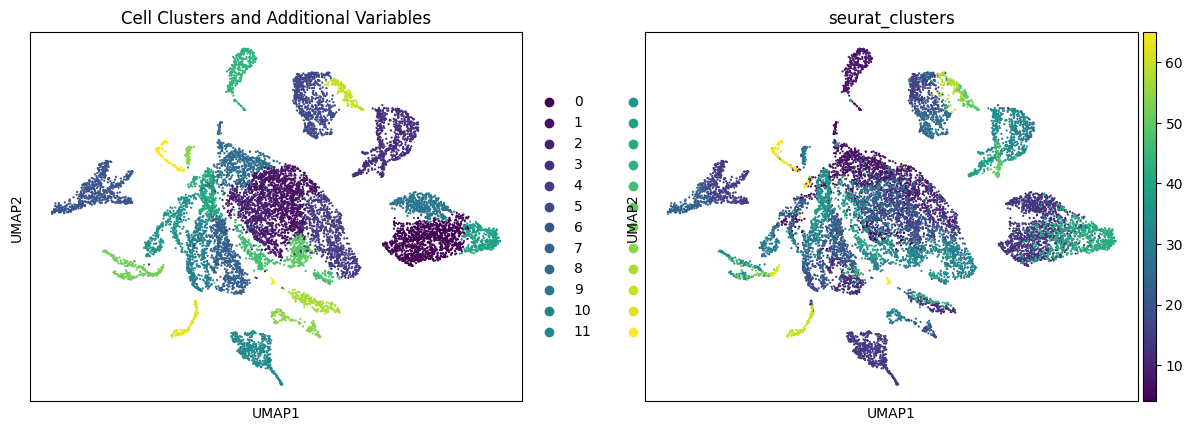

In [31]:
available_colors = ['louvain']
additional_colors = ['seurat_clusters', 'batch']

for color in additional_colors:
    if color in adata.obs.columns:
        available_colors.append(color)
    else:
        print(f"Column '{color}' not found in adata.obs and will be skipped.")

# Plot UMAP with available color variables
sc.pl.umap(adata, color=available_colors, palette='viridis', title='Cell Clusters and Additional Variables')
plt.show()